<p style="font-size: 40px; font-weight: bold; text-align: center;">Traffic Signs Detection Vol_2</p>

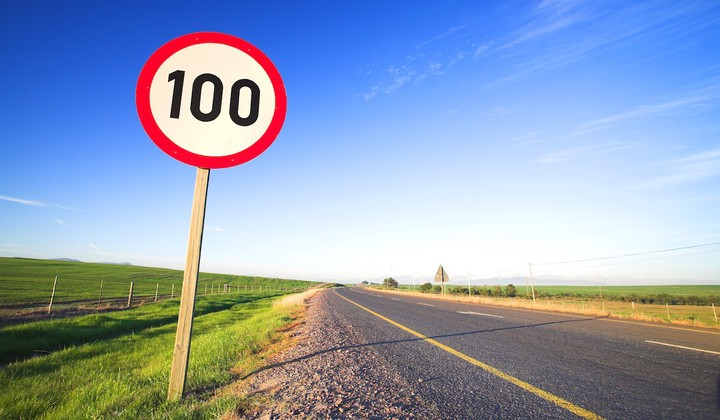

Traffic signs detection is a computer vision project that aims to automatically identify and classify traffic signs in images or video frames. The goal of this project is to develop a system that can accurately recognize traffic signs and understand their meanings in order to assist with navigation and obey traffic regulations. This can be useful for autonomous vehicles, as well as for assisting human drivers. Traffic signs detection systems typically involve training a machine learning model on a large dataset of labeled traffic sign images, and then using the trained model to classify traffic signs in real-time video frames or images. The performance of a traffic signs detection system is typically evaluated based on its ability to accurately classify traffic signs, and to do so in a timely manner.

- 0 - 'Speed limit (20km/h)' 
- 1 - 'Speed limit (30km/h)' 
- 2 - 'Speed limit (50km/h)'
- 3 - 'Speed limit (60km/h)' 
- 4 - 'Speed limit (70km/h)' 
- 5 - 'Speed limit (80km/h)'
- 6 - 'End of speed limit (80km/h) 
- 7 - 'Speed limit (100km/h)' 
- 8 - 'Speed limit (120km/h)'
- 9 - 'No passing' 
- 10 - 'No passing for vehicles over 3.5 metric tons'
- 11 - 'Right-of-way at the next intersection 
- 12 - 'Priority road' 
- 13 - 'Yield 
- 14 - 'Stop' 
- 15 - 'No vehicles'
- 16 - 'Vehicles over 3.5 metric tons prohibited' 
- 17 - 'No entry'  
- 18 - 'General caution' 
- 19 - 'Dangerous curve to the left' 
- 20 - 'Dangerous curve to the right'
- 21 - 'Double curve' 
- 22 - 'Bumpy road'
- 23 - 'Slippery road'
- 24 - 'Road narrows on the right' 
- 25 - 'Road work' 
- 26 - 'Traffic signals' 
- 27 - 'Pedestrians' 
- 28 - 'Children crossing' 
- 29 - 'Bicycles crossing' 
- 30 - 'Beware of ice/snow' 
- 31 - 'Wild animals crossing' 
- 32 - 'End of all speed and passing limits'
- 33 - 'Turn right ahead' 
- 34 - 'Turn left ahead' 
- 35 - 'Ahead only' 
- 36 - 'Go straight or right' 
- 37 - 'Go straight or left' 
- 38 - 'Keep right'
- 39 - 'Keep left' 
- 40 - 'Roundabout mandatory' 
- 41 - 'End of no passing'
- 42 - 'End of no passing by vehicles over 3.5 metric tons'

## Import libraries

In [1]:
# Data Serialization
import pickle
from sklearn.model_selection import GridSearchCV
from keras.models import load_model

# Optimization algorithms
from keras.optimizers import (
    Adam, 
    SGD, 
    RMSprop, 
    Adagrad, 
    Adadelta, 
    Adamax,
    Nadam
)

# Data manipulation and computation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model evaluation
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score
)

# Deep learning models
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    AveragePooling2D,
    Dropout
)
from scikeras.wrappers import KerasClassifier

# Callback functions
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint
)

# Others
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2023-01-30 15:41:44.929184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Functions

In [3]:
# Define the function to create the CNN model
def create_model(
    kernel_size = (5,5),
    optimizer = Adam,
    learning_rate = 0.001,
    pooling_type = AveragePooling2D(),
    dropout_rate = 0.2,
    batch_size = 100,
    epochs = 20
):
    model = Sequential()
    # Adding the first convolutional layer
    model.add(Conv2D(6, kernel_size=kernel_size, activation='relu', input_shape=(32,32,1)))

    # Adding a pooling layer
    model.add(pooling_type)

    # Adding a second convolutional layer
    model.add(Conv2D(16, kernel_size=kernel_size, activation='relu'))

    # Adding a pooling layer
    model.add(pooling_type)

    # Flattening the output
    model.add(Flatten())
    # Adding a fully connected layer with dropout
    model.add(Dropout(dropout_rate))
    model.add(Dense(120, activation='relu'))

    # Adding a fully connected layer with dropout
    model.add(Dropout(dropout_rate))
    model.add(Dense(84, activation='relu'))

    # Adding the output layer
    model.add(Dense(43, activation='softmax'))
    optimizer = optimizer(learning_rate=learning_rate)
    # Compiling the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

## Data import and scalling

In [4]:
# Read the training, testing, and validation data
train = pickle.load(open("traffic-signs-data/train.p", "rb"))
test = pickle.load(open("traffic-signs-data/test.p", "rb"))
valid = pickle.load(open("traffic-signs-data/valid.p", "rb"))

# Assign the features and labels to the corresponding variables
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_valid, y_valid = valid['features'], valid['labels']

# Convert the images in X_train, X_test and X_valid to grayscale using intensity normalization
X_train_norm = np.sum(X_train/3,axis = 3, keepdims = True)
X_test_norm = np.sum(X_test/3,axis = 3, keepdims = True)
X_val_norm = np.sum(X_valid/3,axis = 3, keepdims = True)

# Feature scaling to convert value between -1,1
X_train_norm = (X_train_norm - 128) / 128
X_test_norm = (X_test_norm - 128) / 128
X_val_norm = (X_val_norm - 128) / 128

## Trying apply GridSearchCV

In [5]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=10
)
checkpointer = ModelCheckpoint(
    filepath='Vol_2_best_model.h5', 
    save_best_only=True,
    monitor='val_accuracy'
)

In [7]:
# Define the possible values for the optimizer , learning rate and other hyperparameters
param_grid = {
    'model__pooling_type':[AveragePooling2D(),MaxPooling2D()],
    'model__optimizer': [Adam, SGD, RMSprop, Adamax],
    'model__kernel_size': [(3, 3), (5, 5), (7, 7)],
    'model__learning_rate': [0.001, 0.01, 0.1],
    'model__dropout_rate': [0.0, 0.2, 0.4],
    'model__batch_size': [100,500], 
    'model__epochs': [20,50]
}

# Use KerasClassifier to define the model and GridSearchCV to tune the hyperparameters
model = KerasClassifier(
    model = create_model,
    verbose = 0,
    validation_split = 0.2,
    validation_batch_size = 50,
    callbacks=early_stopping
)

grid_search = GridSearchCV(
    model, 
    param_grid,
    cv=5, 
    n_jobs=-1,
    error_score='raise',
)

# Fitting grid_search
grid_search.fit(X_train_norm, y_train)

# Print the best hyperparameters and the corresponding score
print(grid_search.best_params_)

{'model__batch_size': 500, 'model__dropout_rate': 0.2, 'model__epochs': 50, 'model__kernel_size': (5, 5), 'model__learning_rate': 0.01, 'model__optimizer': <class 'keras.optimizers.optimizer_v2.adamax.Adamax'>, 'model__pooling_type': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f7b9131b670>}


## Final best model

Epoch 1/50
70/70 [==============================] - 3s 35ms/step - loss: 2.4459 - accuracy: 0.3387 - val_loss: 1.0698 - val_accuracy: 0.6776
Epoch 2/50
70/70 [==============================] - 2s 32ms/step - loss: 0.8185 - accuracy: 0.7492 - val_loss: 0.5309 - val_accuracy: 0.8528
Epoch 3/50
70/70 [==============================] - 2s 32ms/step - loss: 0.4836 - accuracy: 0.8572 - val_loss: 0.3198 - val_accuracy: 0.9138
Epoch 4/50
70/70 [==============================] - 2s 32ms/step - loss: 0.3416 - accuracy: 0.9004 - val_loss: 0.2934 - val_accuracy: 0.9166
Epoch 5/50
70/70 [==============================] - 2s 32ms/step - loss: 0.2686 - accuracy: 0.9192 - val_loss: 0.2663 - val_accuracy: 0.9249
Epoch 6/50
70/70 [==============================] - 2s 33ms/step - loss: 0.2235 - accuracy: 0.9347 - val_loss: 0.2275 - val_accuracy: 0.9379
Epoch 7/50
70/70 [==============================] - 2s 33ms/step - loss: 0.1851 - accuracy: 0.9460 - val_loss: 0.1972 - val_accuracy: 0.9429
Epoch 8/50
70

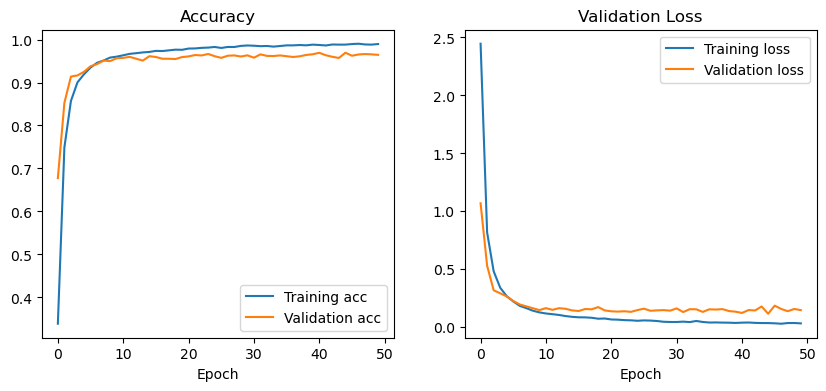

In [10]:
# Define parameters
batch_size,dropout_rate,epochs,kernel_size,learning_rate,optimizer,pooling_type = grid_search.best_params_.values()

# Define model
model = create_model(kernel_size,optimizer,learning_rate,pooling_type,dropout_rate,batch_size,epochs)

# Fitting model
history = model.fit(
    X_train_norm, 
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose=1,
    validation_data=(X_val_norm, y_valid), 
    callbacks=[early_stopping, checkpointer]
)

# Evaluating plots
fig, axs = plt.subplots(1, 2,figsize=(10,4))

# Get the length of the data
history_len = len(history.history['accuracy'])

# Create a dictionary to store the plots, labels and titles
plots = {
    'acc':['accuracy','val_accuracy','Accuracy'],
    'loss':['loss','val_loss','Validation Loss'],
}

# Iterate over the dictionary and plot the data
for i, (key,value) in enumerate(plots.items()):
    # Plot the training and validation data
    axs[i].plot(range(history_len), history.history[value[0]],label = f'Training {key}')
    axs[i].plot(range(history_len), history.history[value[1]],label = f'Validation {key}')
    # Add the legend
    axs[i].legend()
    # Set the title
    axs[i].set_title(value[2])
    # Set the x-axis label
    axs[i].set_xlabel('Epoch')
# Show the plot
plt.show()

In [30]:
# Generate generalization metrics
score = model.evaluate(X_test_norm, y_test, verbose=0)
print(f'Test loss: {score[0]}\nTest accuracy: {score[1]}')

# Saving model
model.save('Vol_2_best_model.h5')

Test loss: 0.39967119693756104
Test accuracy: 0.9410926103591919


395/395 [==============================] - 1s 2ms/step


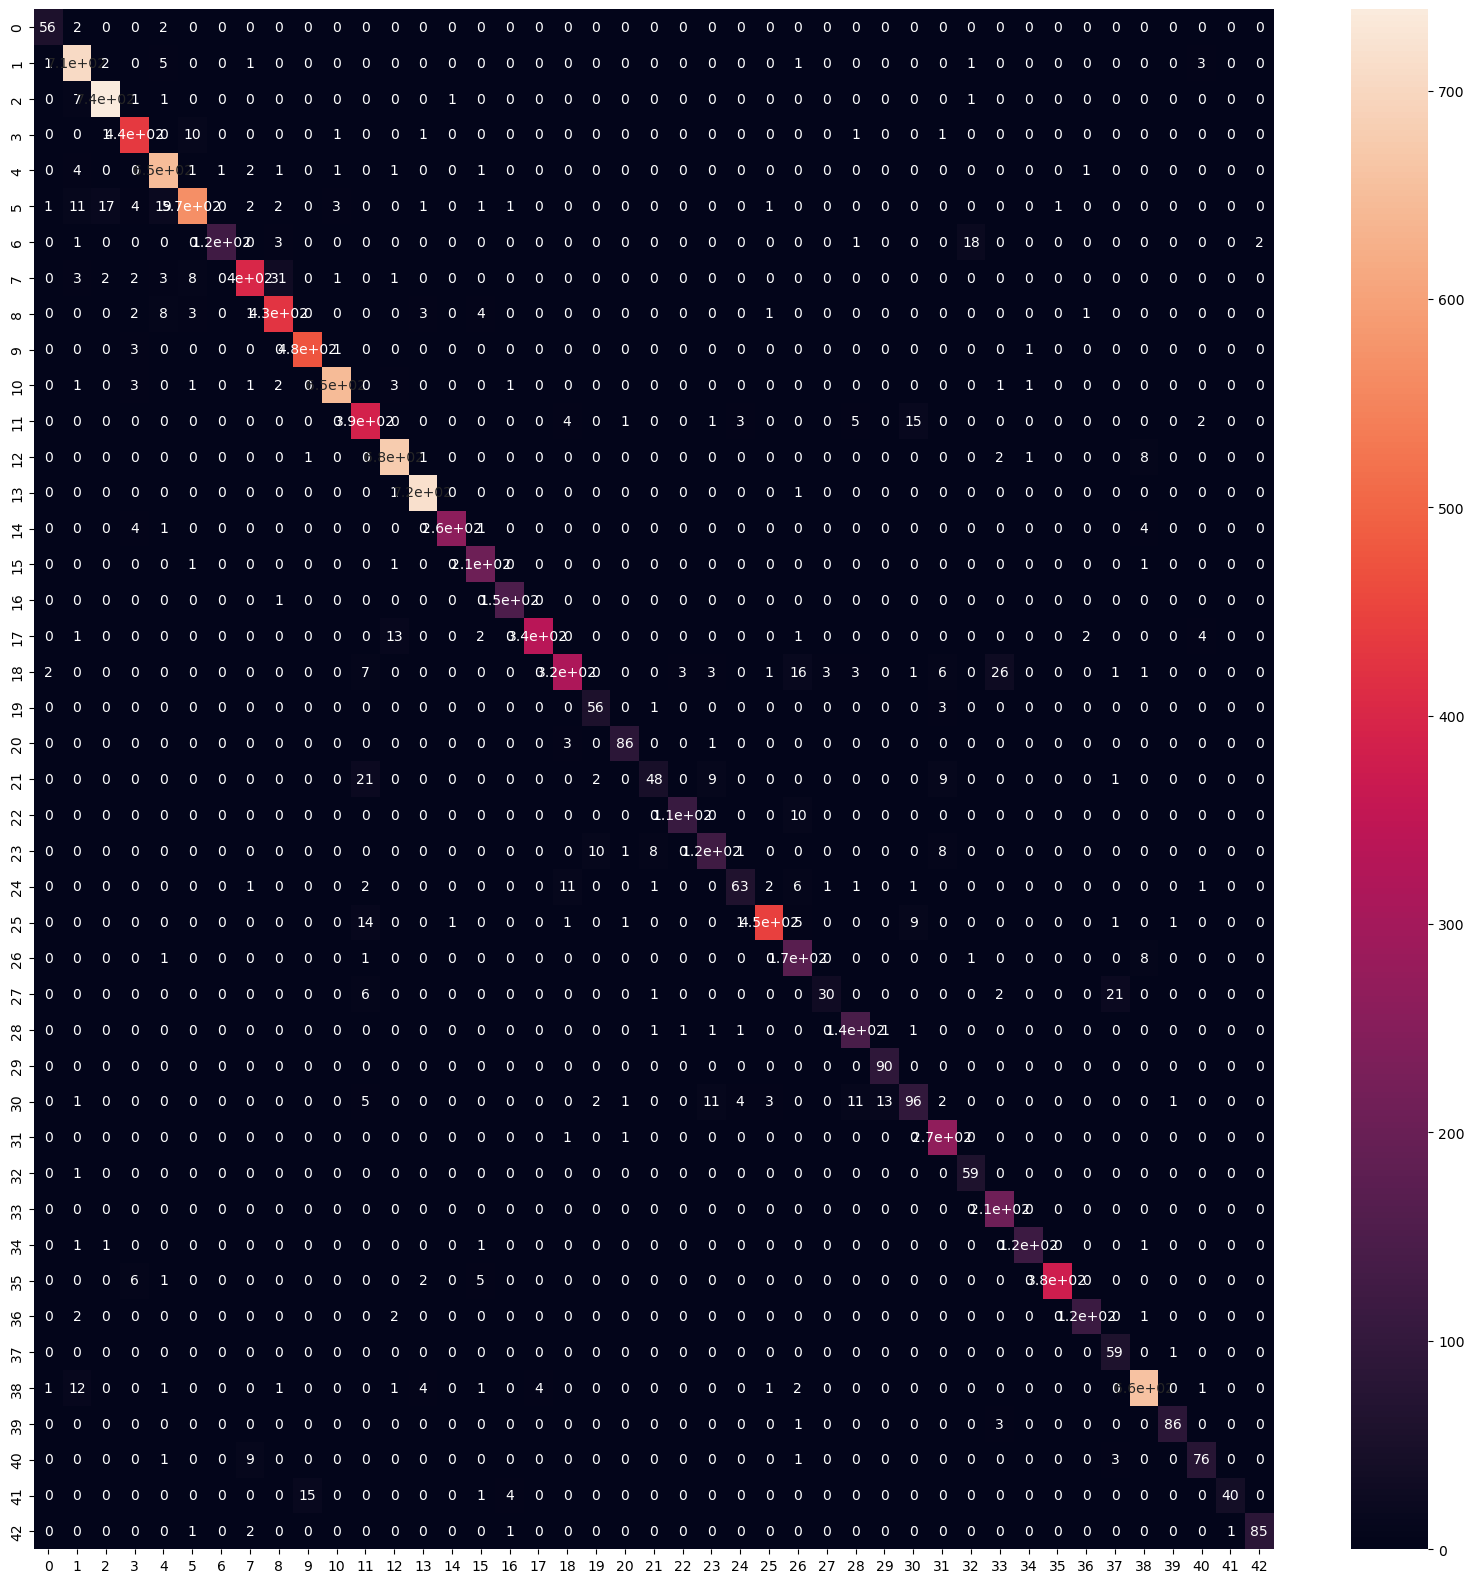

In [31]:
# Confusion_matrix

"""
    A confusion matrix is a table used
    to evaluate the performance of a 
    classification algorithm, showing 
    predicted vs actual classifications 
    in the form of a matrix with diagonal 
    representing correct predictions while 
    off-diagonal elements are incorrect ones.
"""

plt.figure(figsize=(20,20))

sns.heatmap(
    confusion_matrix(
        y_test,
        np.argmax(
            model.predict(X_test_norm),
            axis = 1
        )
    ),annot=True
)

plt.show()

In [13]:
# Observating classification report

"""
    As the "classification report" metric 
    results cannot be sorted to make it easier 
    observating. We will write the code 
    below for optimization.
"""

print(
    classification_report(
        y_test,
        np.argmax(
            model.predict(X_test_norm),
            axis=1
        )
    )
)

395/395 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.92      0.93      0.93        60
           1       0.94      0.98      0.96       720
           2       0.97      0.99      0.98       750
           3       0.95      0.97      0.96       450
           4       0.94      0.98      0.96       660
           5       0.96      0.90      0.93       630
           6       0.99      0.83      0.91       150
           7       0.95      0.89      0.92       450
           8       0.91      0.95      0.93       450
           9       0.97      0.99      0.98       480
          10       0.99      0.98      0.98       660
          11       0.87      0.93      0.90       420
          12       0.97      0.98      0.97       690
          13       0.98      1.00      0.99       720
          14       0.99      0.96      0.98       270
          15       0.92      0.99      0.95       210
          16       0.96   

## Conclusion sections

In [15]:
# Collecting precision values in main model
classification_report_dct = classification_report(
    y_test, 
    np.argmax(
        model.predict(X_test_norm),
        axis=1
    ),output_dict=True
)
precision_list = [np.around(classification_report_dct[i]['precision'], 2) for i in classification_report_dct if len(i)<3]

# Collecting precision values in old model
classification_report_dct = classification_report(
    y_test, 
    np.argmax(
        load_model('Vol_1_best_model.h5').predict(X_test_norm),
        axis=1
    ),output_dict=True
)
precision_list_old_model = [np.around(classification_report_dct[i]['precision'], 2) for i in classification_report_dct if len(i)<3]

395/395 [==============================] - 1s 2ms/step


In [16]:
# Outputing resuilts to make conclusion
conclusion_df = pd.concat([
    pd.DataFrame(precision_list, columns=['New model precision score']),
    pd.DataFrame(precision_list_old_model, columns=['Old model precision score']),
    pd.DataFrame(pd.Series(precision_list) - pd.Series(precision_list_old_model),columns=['Difference'])
],axis=1)
print('Sorted by Old model precision score')
conclusion_df.sort_values(by = 'Old model precision score').head(20)

Sorted by Old model precision score


,New model precision score,Old model precision score,Difference
32,0.74,0.31,0.43
27,0.88,0.36,0.52
0,0.92,0.47,0.45
20,0.95,0.53,0.42
23,0.82,0.55,0.27
26,0.79,0.56,0.23
19,0.80,0.59,0.21
40,0.87,0.63,0.24
41,0.98,0.63,0.35
29,0.87,0.71,0.16


## Conclusion

- <b>Conclusion</b>
    - The new model predicts with greater accuracy And the average difference between old<br> predictions and the new ones equals : 0.11
    - Thanks to the hyperparameter tuning, I discovered optimal parameters where the training was more stable and <br>labels that were predicted with less than 50% precision in the old version were now predicted with <br>a higher precision (70+). I think this method is worth the time spent on it. The grid search <br>took 2 days to find the optimal hyperparameters.